## Calculate emission spectrum with/without various absorbers
This loads the netCDF output file from the `out` folder, and recalculates the radiative transfer with absorbers removed one at a time.

In [1]:
# Import system packages
using Printf
using Plots
using LaTeXStrings
using NCDatasets

In [2]:
# Set directory
ROOT_DIR = abspath(joinpath(pwd(),"../"))
ENV["RAD_DIR"] = joinpath(ROOT_DIR,"socrates")

"/Users/nichollsh/Projects/AGNI/socrates"

In [3]:
# Import AGNI
using AGNI
import AGNI.atmosphere as atmosphere
import AGNI.energy as energy
import AGNI.dump as dump
import AGNI.plotting as plotting
import AGNI.setpt as setpt

# Disable logging from AGNI module
AGNI.setup_logging("",1)

### Read information from netCDF file

In [4]:
# Open file 
output_dir = joinpath(ROOT_DIR, "out")
fpath = joinpath(output_dir, "atm.nc")
if !isfile(fpath)
    error("The file '$fpath' does not exist")
end 
ds = Dataset(fpath,"r")


# Get all of the information that we need 
nlev_c::Int = length(ds["p"][:])

#   temperature arrays 
input_tmpl::Array{Float64,1} = ds["tmpl"][:]
input_tmp::Array{Float64,1}  = ds["tmp"][:]

#   pressure arrays 
input_pl::Array{Float64,1} = ds["pl"][:]
input_p::Array{Float64,1}  = ds["p"][:]

#   gas names
raw_gases::Array{Char,2} = ds["gases"][:,:]
num_gas::Int = size(raw_gases)[2]
input_gases::Array{String,1} = []
for i in 1:num_gas 
    push!(input_gases, strip(String(raw_gases[:,i])))
end 

# gas VMRs 
raw_vmrs::Array{Float64, 2} = ds["x_gas"][:,:]
input_vmrs::Dict{String, Array{Float64,1}} = Dict()      # dict of Arrays
input_vmrs_scalar::Dict{String, Float64} = Dict()        # dict of Floats (surface values)
for i in 1:num_gas
    g = input_gases[i]
    input_vmrs[g]     = zeros(Float64, nlev_c)
    input_vmrs[g][:] .= raw_vmrs[i, :] 

    input_vmrs_scalar[g] = input_vmrs[g][end]
end 

# surface 
input_tsurf::Float64   = ds["tmp_surf"][1]
input_radius::Float64  = ds["planet_radius"][1]
input_gravity::Float64 = ds["surf_gravity"][1]

# stellar properties 
input_inst::Float64   = ds["instellation"][1]
input_s0fact::Float64 = ds["inst_factor"][1]
input_albedo::Float64 = ds["bond_albedo"][1]
input_zenith::Float64 = ds["zenith_angle"][1]

# flags 
input_flag_rayleigh::Bool  = Bool(ds["flag_rayleigh"][1] == 'y')
input_flag_thermo::Bool    = Bool(ds["thermo_funct"][1] == 'y')
input_flag_continuum::Bool = Bool(ds["flag_continuum"][1] == 'y')

# Close file 
close(ds);

# spectral file is already in the folder 
spectral_file = abspath(joinpath(ROOT_DIR, "out", "runtime.sf"))

"/Users/nichollsh/Projects/AGNI/out/runtime.sf"

In [5]:
# display(input_vmrs)

# get surface vmrs as an array 
_gas_surfs::Array{Float64,1} = []
for g in input_gases 
    push!(_gas_surfs, input_vmrs_scalar[g])
end 

# get sorted mask
gas_mask = reverse(sortperm(_gas_surfs))
;

In [6]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir, 
                        spectral_file,
                        input_inst, input_s0fact, input_albedo, input_zenith,
                        input_tsurf,
                        input_gravity, input_radius,
                        nlev_c, input_pl[end], input_pl[1],
                        input_vmrs_scalar, "",
                        flag_gcontinuum=input_flag_continuum,
                        flag_rayleigh=input_flag_rayleigh,
                        thermo_functions=input_flag_thermo,
                        overlap_method=2
                        )
atmosphere.allocate!(atmos, "")

[ INFO  ] Composition set by dict 
[ INFO  ] Using pre-existing spectral file without modifications 
[ INFO  ] Allocated atmosphere with composition: 
[ INFO  ]       1 OCS     0.00e+00 (NO_OPACITY) 
[ INFO  ]       2 FeH     0.00e+00 (NO_OPACITY NO_THERMO) 
[ INFO  ]       3 H2S     0.00e+00 (NO_OPACITY) 
[ INFO  ]       4 HNO3    7.17e-17 (NO_OPACITY) 
[ INFO  ]       5 SO2     0.00e+00 (NO_OPACITY) 
[ INFO  ]       6 S8      0.00e+00 (NO_OPACITY) 
[ INFO  ]       7 N2      6.08e-02  
[ INFO  ]       8 N2O5    3.38e-30 (NO_OPACITY NO_THERMO) 
[ INFO  ]       9 O3      1.35e-15 (NO_OPACITY) 
[ INFO  ]      10 C2H4    7.11e-13 (NO_OPACITY) 
[ INFO  ]      11 CH3     1.88e-09 (NO_OPACITY) 
[ INFO  ]      12 NH3     6.87e-08 (NO_OPACITY) 
[ INFO  ]      13 H2CO    3.30e-07 (NO_OPACITY NO_THERMO) 
[ INFO  ]      14 SiO2    0.00e+00 (NO_OPACITY) 
[ INFO  ]      15 O2      2.75e-07 (NO_OPACITY) 
[ INFO  ]      16 FeS     0.00e+00 (NO_OPACITY) 
[ INFO  ]      17 CO      8.77e-01  
[ INFO  ] 

In [7]:
atmos.tmpl[:] .= input_tmpl[:]
atmos.tmp[:] .= input_tmp[:]

atmos.pl[:] .= input_pl[:]
atmos.p[:] .= input_p[:]

for g in input_gases
    atmos.gas_vmr[g][:] .= input_vmrs[g]
end 

atmosphere.calc_layer_props!(atmos)

true

### Do radtrans with different absorbers REMOVED from atmosphere

In [8]:
atm_arr = atmosphere.Atmos_t[]

for (i,g) in enumerate(input_gases)
    @printf("Running radtrans without '%s' \n",g)

    # set all to "true" value 
    for gg in input_gases 
        atmos.gas_vmr[gg][:] .= input_vmrs[gg][:]
    end

    # set ONLY this gas to zero
    fill!(atmos.gas_vmr[g], 0.0)

    # DO NOT UPDATE LAYER PROPERTIES

    # reset upward fluxes (just in case)
    fill!(atmos.band_u_lw, 0.0)
    fill!(atmos.band_u_sw, 0.0)

    # do radtrans with this composition
    energy.radtrans!(atmos, true)   # LW 
    energy.radtrans!(atmos, false)  # SW
    
    # Store result
    push!(atm_arr, deepcopy(atmos))
end 

@printf("Running radtrans for all gases \n")
for g in input_gases 
    atmos.gas_vmr[g][:] .= input_vmrs[g][:]
end
energy.radtrans!(atmos, true)   # LW 
energy.radtrans!(atmos, false)  # SW
push!(atm_arr, deepcopy(atmos))

println("Done!")

Running radtrans without 'H2' 
Running radtrans without 'CO' 
Running radtrans without 'H2O' 
Running radtrans without 'CO2' 
Running radtrans without 'N2' 
Running radtrans without 'C2H4' 
Running radtrans without 'FeS' 
Running radtrans without 'H2SO4' 
Running radtrans without 'O2' 
Running radtrans without 'OH' 
Running radtrans without 'SO' 
Running radtrans without 'SiO' 
Running radtrans without 'CH4' 
Running radtrans without 'H2S' 
Running radtrans without 'HCN' 
Running radtrans without 'NH3' 
Running radtrans without 'OCS' 
Running radtrans without 'S2' 
Running radtrans without 'S8' 
Running radtrans without 'SO2' 
Running radtrans without 'SiO2' 
Running radtrans without 'O3' 
Running radtrans without 'N2O' 
Running radtrans without 'NO' 
Running radtrans without 'NO2' 
Running radtrans without 'HNO3' 
Running radtrans without 'FeH' 
Running radtrans without 'PH3' 
Running radtrans without 'C2H2' 
Running radtrans without 'NO3' 
Running radtrans without 'N2O5' 
Running rad

### Write as separate netCDF files

In [9]:
# for (i,g) in enumerate(input_gases)
#     dump.write_ncdf(atm_arr[i], joinpath(output_dir, "$g.nc"))
# end

### Make plot of spectra

In [23]:
# plot parameters 
fs=12
lw=1.5
la=0.8
xmax = 4e4
logy=false
atm_lvl=1

1

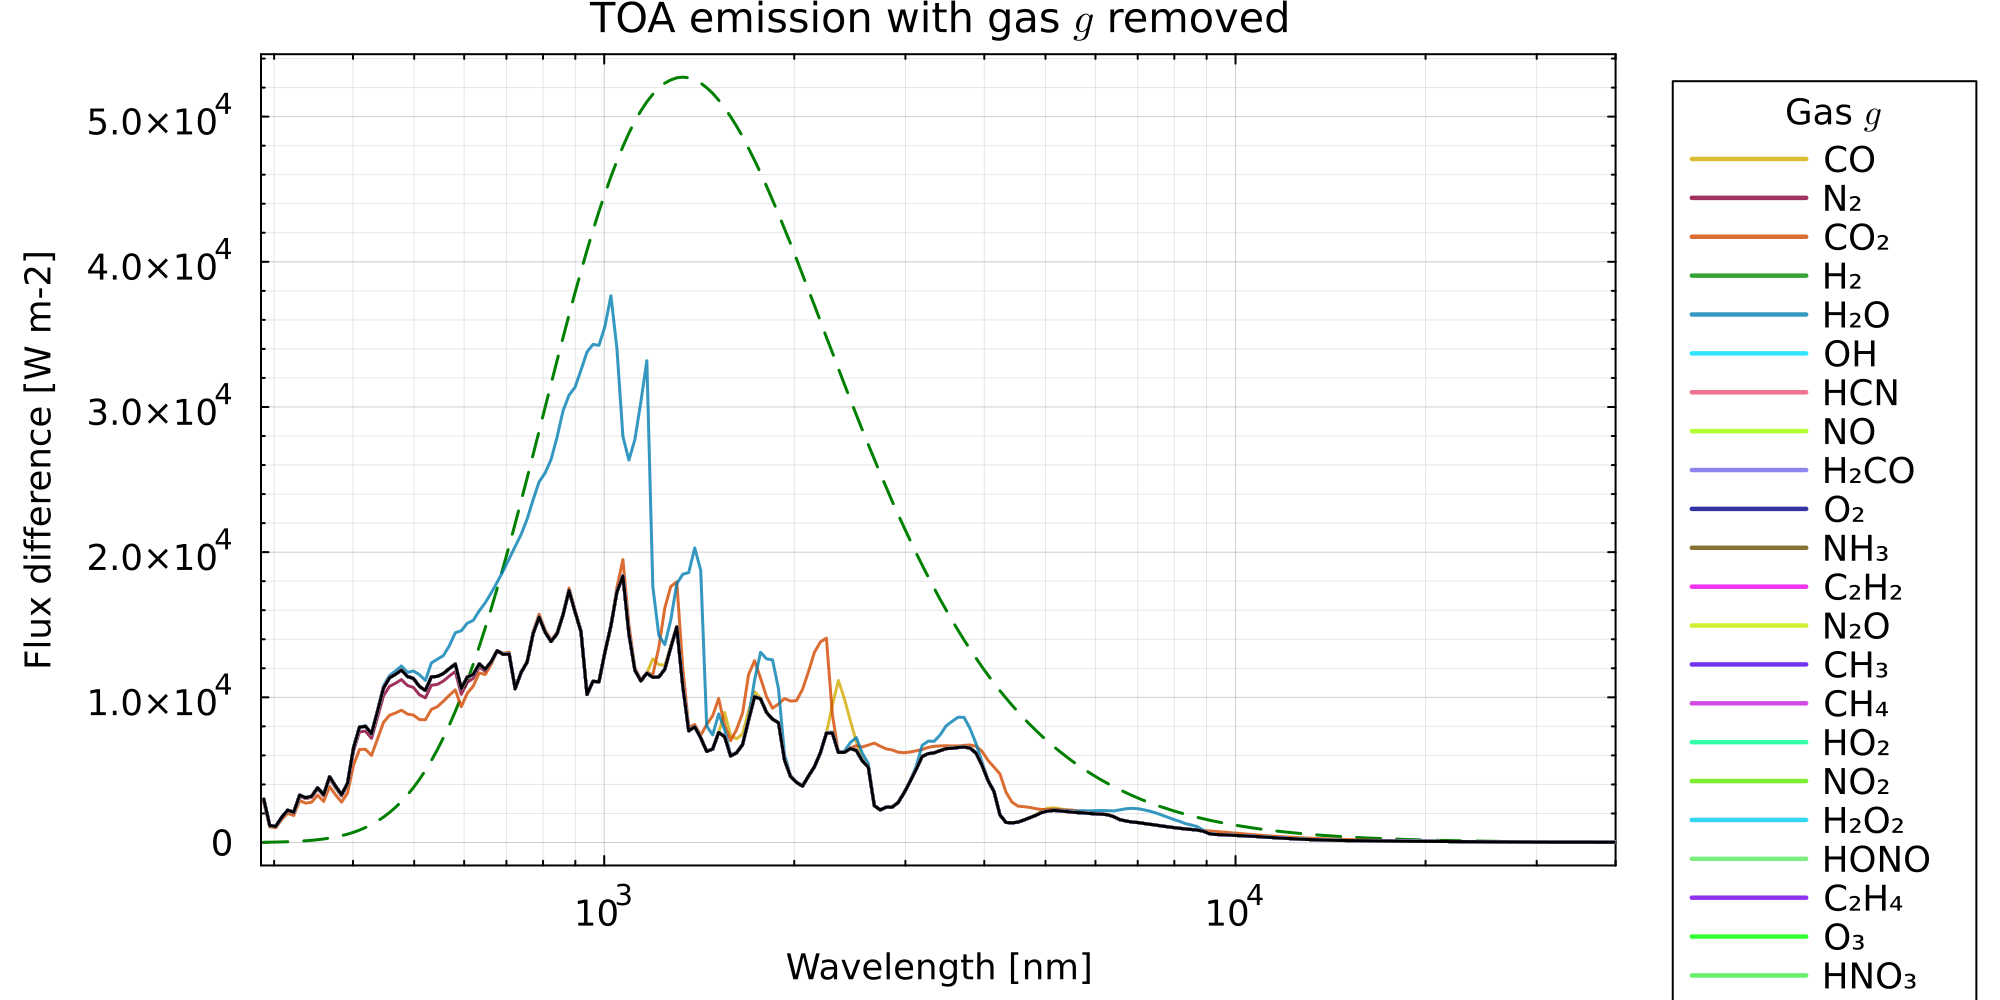

"/Users/nichollsh/Projects/AGNI/out/blame_emission.pdf"

In [26]:
# initialise plot 
if atm_lvl == 1
    title = L"TOA emission with gas $g$ removed"
else
    title = L"Upward flux (i=%$atm_lvl) with gas $g$ removed" 
end 
plt = plot(framestyle=:box, size=(1000,500), dpi=200, 
                leg=:outertopright, legcolumn=-1,
                tickfontsize=fs, guidefontsize=fs, legendfontsize=fs, 
                legendtitlefontsize=fs, leg_title=L"Gas $g$",
                left_margin = 6Plots.mm,
                bottom_margin = 6Plots.mm,
                title=title)
          

# band centres
x_arr = 0.5 * 1e9 * (atm_arr[1].bands_min + atm_arr[1].bands_max)
xlim = (x_arr[1]*0.99, xmax)

# PLOT surface emission + surface reflection
# dashed green line 
y_arr = atm_arr[1].band_u_lw[end,:] + atm_arr[1].band_u_sw[end,:]
plot!(plt, x_arr, y_arr, linewidth=lw, linestyle=:dash, linecolor="green", label="")

# PLOT spectrum with each gas removed
# coloured solid lines
for i in gas_mask
    this_atm = atm_arr[i]
    
    y_arr = this_atm.band_u_lw[atm_lvl,:] + this_atm.band_u_sw[atm_lvl,:]

    lbl = this_atm.gas_dat[input_gases[i]].plot_label
    col = this_atm.gas_dat[input_gases[i]].plot_color

    plot!(plt, x_arr, y_arr, linewidth=lw, label=lbl, linealpha=la, linecolor=col)
end 

# PLOT spectrum with all included
# black solid line
this_atm = atm_arr[end]
y_tot = this_atm.band_u_lw[atm_lvl,:] + this_atm.band_u_sw[atm_lvl,:]
plot!(plt, x_arr, y_tot, linewidth=lw, label="None", linestyle=:solid, linecolor="black",)

xlabel!(plt, "Wavelength [nm]")
xaxis!(plt, minorgrid=true, xlims=xlim, xscale=:log10)
ylabel!(plt, "Flux difference [W m-2]")
if logy
    yaxis!(plt, yscale=:log10)
end

display(plt)
savefig(plt,joinpath(output_dir,"blame_emission.pdf"))